In [1]:
import pandas
import pandas_profiling as pp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

## data exploration

In [2]:
df = pandas.read_csv("data/train.csv")
df.set_index("PassengerId", inplace=True)

test = pandas.read_csv("data/test.csv")
test.set_index("PassengerId", inplace=True)

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


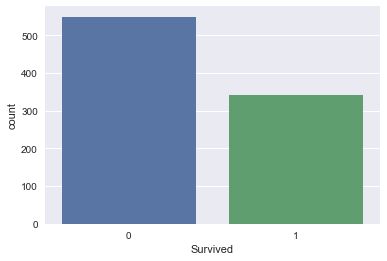

In [7]:
sb.countplot("Survived", data=df);

decently balanced classes.

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


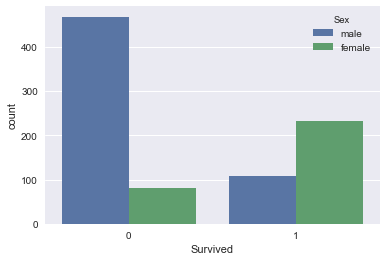

In [8]:
sb.countplot("Survived", data=df, hue="Sex");

this is the baseline.

In [9]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
len(df)

891

In [11]:
pp.ProfileReport(df)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,7
Categorical,4
Date,0
Text (Unique),1
Rejected,0
Distinct count,89


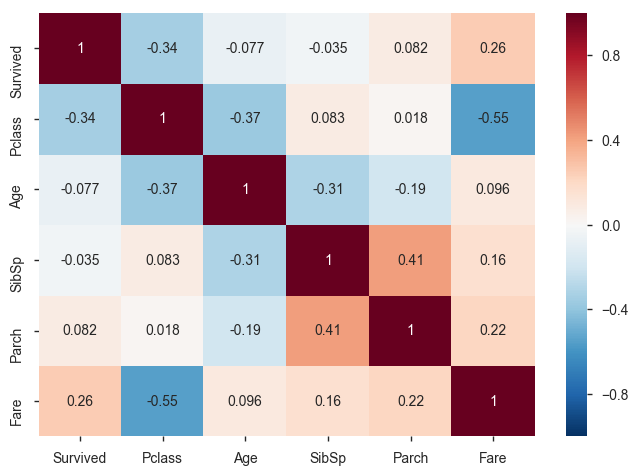

In [12]:
sb.heatmap(df.corr(), annot=True);

## feature engineering

In [13]:
from sklearn_pandas import DataFrameMapper
import sklearn
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, Imputer, \
                                StandardScaler, OneHotEncoder, FunctionTransformer

we'll programmatically roll transformations/feature extractions/etc into a `DataFrameMapper` object from `sklearn-pandas`, which lets us map specific scikit-learn preprocessing transformer objects to columns in a dataframe.

In [14]:
mapper = DataFrameMapper([], input_df=True, df_out=True)

### get target variable

In [15]:
mapper.features.append(("Survived", None))

### encode gender

In [16]:
mapper.features.append(("Sex", LabelBinarizer()))

In [17]:
df['SexMapped'] = LabelBinarizer().fit_transform(df.Sex)

### encode passenger class

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


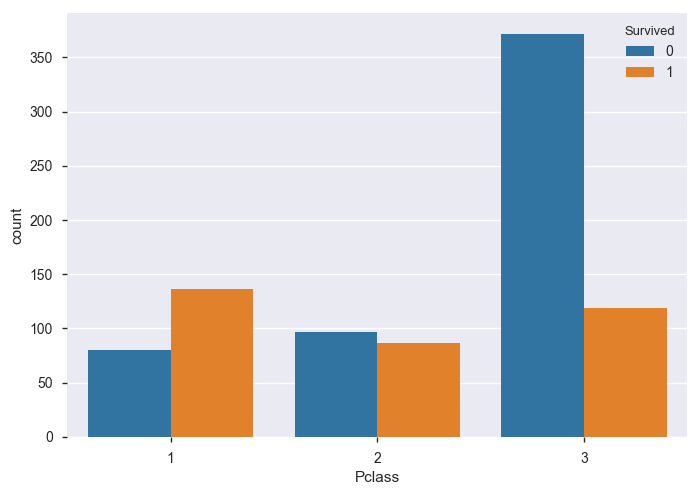

In [18]:
sb.countplot("Pclass", data=df, hue='Survived');

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


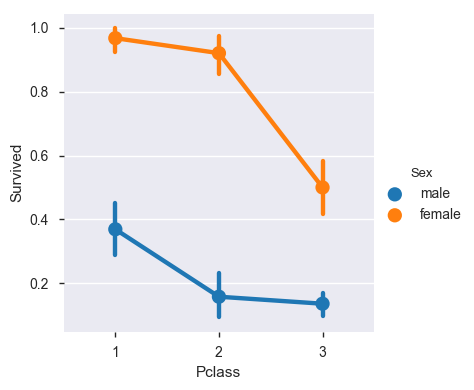

In [19]:
sb.factorplot("Pclass", "Survived", "Sex", data=df);

actually encodes some ordinality for both sexes, so let's leave as-is (in the `DataFrameMapper` this is encoded as using `None` for the transformer).

In [20]:
mapper.features.append(("Pclass", None))

### passenger name data

try extracting title from Name:

In [21]:
df.Name.head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

 this bit looks a little gnarly since it's chaining `pandas` built-in string operations (which will run substantially faster for large datasets), but it makes sense sequentially given the above:
 
 * split around the comma (separating the last name from the rest) and take the rest
 * split around the period following the title and take the first element
 * split around whitespace and take the last element (getting title from things like "the Countess")

In [22]:
df['Title'] = df.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.split(' ').str.get(-1)

convenient trick: since we're using the provided `DataFrameMapper` from `sklearn-pandas` to programmatically apply specific transforms to particular columns, we can roll this transformation into an object complying with scikit-learn's `Transformer` class spec so that everything will play nicely with each other.

In [23]:
class TitleExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.str.split(',').str.get(1).str.split('.').str.get(0).str.split(' ').str.get(-1)

In [24]:
TitleExtractor().transform(df.Name).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Don           1
Jonkheer      1
Capt          1
Countess      1
Mme           1
Lady          1
Sir           1
Ms            1
Name: Name, dtype: int64

In [25]:
TitleExtractor().transform(test.Name).value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Dona        1
Ms          1
Name: Name, dtype: int64

looks good.

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


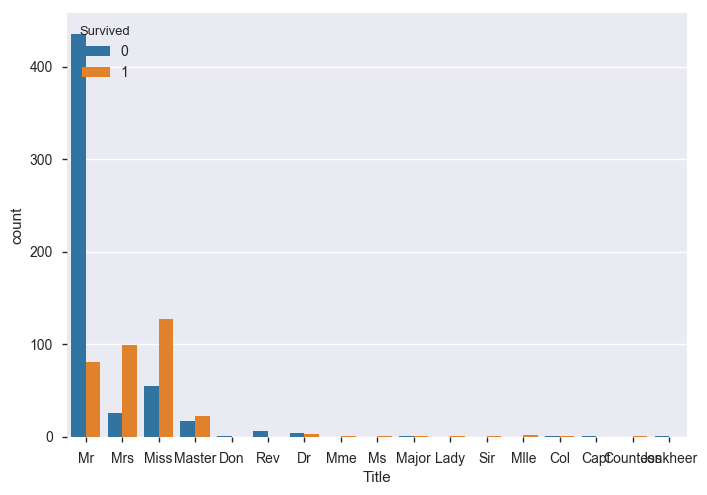

In [26]:
sb.countplot("Title", data=df, hue="Survived");

In [27]:
df.groupby("Title").Survived.agg(["sum", "count"]).apply(lambda row: row['sum']/row['count'], axis=1).sort_values(ascending=False)

Title
Sir         1.000000
Lady        1.000000
Ms          1.000000
Countess    1.000000
Mme         1.000000
Mlle        1.000000
Mrs         0.792000
Miss        0.697802
Master      0.575000
Major       0.500000
Col         0.500000
Dr          0.428571
Mr          0.156673
Rev         0.000000
Jonkheer    0.000000
Don         0.000000
Capt        0.000000
dtype: float64

let's try to munge these down to more manageable categories

In [28]:
noble = ("Sir", "Lady", "Countess", "Count", "Dona")
woman = ("Ms", "Mme", "Mlle", "Mrs", "Miss")

def munge_titles(title):
    if title in noble:
        return "noble"
    elif title in woman:
        return "woman"
    else:
        return "other"
    
class TitleMunger(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(munge_titles)

In [29]:
TitleMunger().transform(df.Title).value_counts()

other    577
woman    311
noble      3
Name: Title, dtype: int64

In [30]:
df['TitleMunged'] = TitleMunger().transform(df.Title)

In [31]:
titles = df.groupby(["Sex", "TitleMunged"]).Survived.agg(["sum", "count"])
(titles['sum']/titles['count'])

Sex     TitleMunged
female  noble          1.00000
        other          1.00000
        woman          0.73955
male    noble          1.00000
        other          0.18750
dtype: float64

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


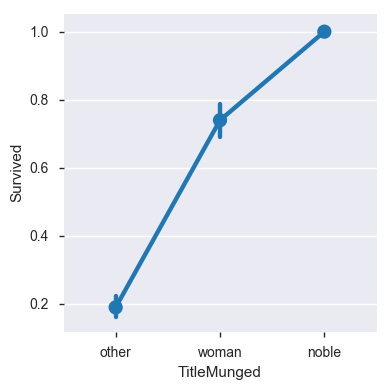

In [32]:
sb.factorplot(x="TitleMunged", y="Survived", data=df);

two options here: one-hot encode the titles as typical for categoricals, or retain ordinality in their rank as we did for `Pclass`.  I'm tempted to try the latter - we'll roll an encoder class to make sure we're in the right order (since the `fit` functionality would put the class names in hash order, rather than ranking.

In [33]:
# one-hot encoding title feature
# mapper.features.append(("Name", [TitleExtractor(), TitleMunger(), LabelBinarizer()], {"alias": "Title"}))

# try retaining ordinality?
class TitleEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.replace({"other": 0, "woman": 1, "noble": 2})
    
mapper.features.append(("Name", [TitleExtractor(), TitleMunger(), TitleEncoder()], {"alias": "Title"}))

In [34]:
class NameLengthExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.str.len()

In [35]:
df['NameLength'] = NameLengthExtractor().transform(df.Name)

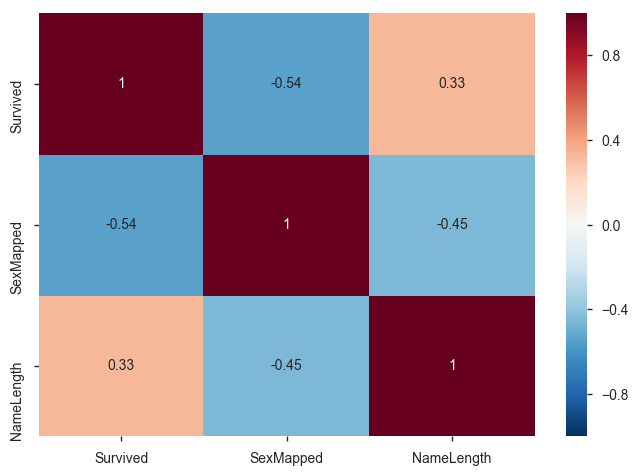

In [36]:
sb.heatmap(df.loc[:, ["Survived", "SexMapped", "NameLength"]].corr(), annot=True);

In [37]:
df.groupby("Sex").NameLength.mean()

Sex
female    32.608280
male      23.894281
Name: NameLength, dtype: float64

extracting total length of name for shits and giggles, seems the correlation between name length and survival is largely due to correlation to gender (with female passengers having longer names in on average).

### passenger fare

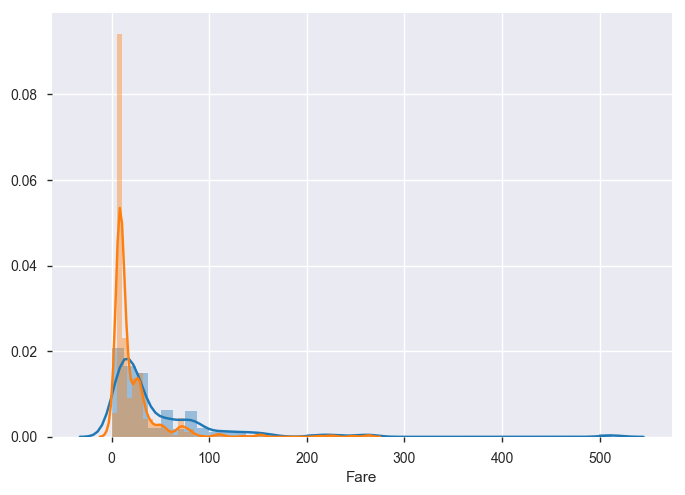

In [38]:
sb.distplot(df[df.Survived == 1].Fare);
sb.distplot(df[df.Survived == 0].Fare);

Cheaper fares more likely to die.

In [39]:
print(df.Fare.isnull().sum())
print(test.Fare.isnull().sum())

0
1


In [40]:
df[df.Fare == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexMapped,Title,TitleMunged,NameLength
PassengerId,,,,,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,1,Mr,other,19
264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1,Mr,other,21
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,1,Mr,other,28
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1,Mr,other,27
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,1,Mr,other,31
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1,Mr,other,30
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1,Mr,other,21
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,1,Mr,other,32
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,1,Mr,other,19


Nulls are obviously missing data, and I'm quite dubious of zero fares as well... let's impute these to the median fares of the corresponding classes.

In [41]:
class SmartFareImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        fares = X.loc[X.Fare.notnull() & (X.Fare > 0), :].groupby('Pclass').Fare.median()
        
        def impute(row):
            if row.isnull().loc["Fare"] or row.Fare == 0:
                return fares.loc[row.loc["Pclass"]]
            else:
                return row.loc["Fare"]
            
        return X.apply(impute, axis=1)

In [42]:
class FareScaler(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.map(np.log)

In [43]:
mapper.features.append((["Fare", "Pclass"], [SmartFareImputer(), FareScaler()], {"alias": "Fare"}))

### embarkation point

In [44]:
df.groupby("Embarked").Survived.agg(["sum", "count"]).apply(lambda row: row['sum']/row['count'], axis=1).sort_values(ascending=False)

Embarked
C    0.553571
Q    0.389610
S    0.336957
dtype: float64

Cherbourg more likely to survive than Queenstown or Southampton.  Presumably class distinction?

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


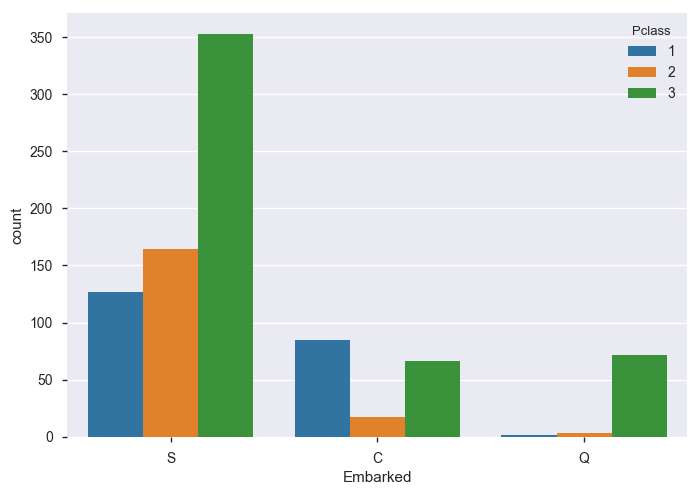

In [45]:
sb.countplot("Embarked", data=df, hue="Pclass");

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


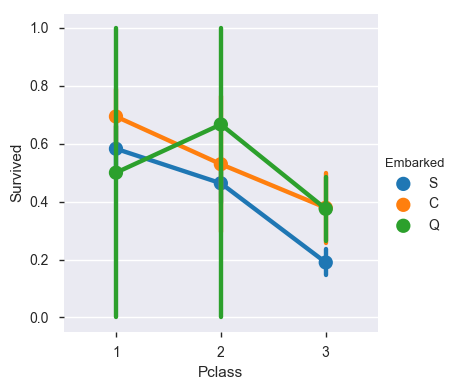

In [46]:
sb.factorplot(x='Pclass', y="Survived", hue="Embarked", data=df);

although the bulk of the passengers were from southampton.

In [47]:
df.Embarked.isnull().sum()

2

In [48]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexMapped,Title,TitleMunged,NameLength
PassengerId,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,Miss,woman,19
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,Mrs,woman,41


let's one-hot encode this.

In [49]:
class CategoricalImputer(TransformerMixin):
    def __init__(self, value=None):
        self.value = value
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(self.value)

In [50]:
mapper.features.append(("Embarked", [CategoricalImputer("unknown"), LabelBinarizer()]))

### Age imputation

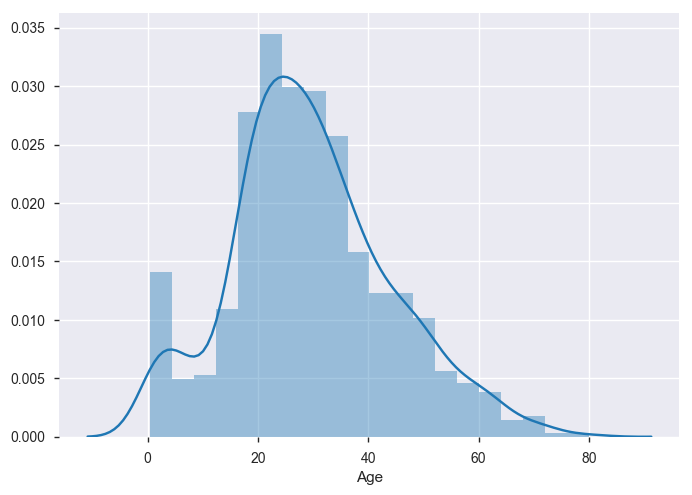

In [51]:
sb.distplot(df[df.Age.notnull()].Age);

problem is the 20% nulls.

In [52]:
df[df.Age.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexMapped,Title,TitleMunged,NameLength
PassengerId,,,,,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,Mr,other,16
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,Mr,other,28
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0,Mrs,woman,23
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,1,Mr,other,23
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0,Miss,woman,29
30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S,1,Mr,other,19
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,0,Mrs,woman,46
33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,0,Miss,woman,24
37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,1,Mr,other,16


let's impute by gender and class, that should be a decent population representation without overspecifying/getting into sparse data problems.

In [53]:
df.groupby(['Sex', 'Pclass']).Age.mean()

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

In [54]:
class SmartAgeImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ages = X.groupby(['Sex', 'Pclass']).Age.mean()
        
        def impute(row):
            if row.notnull().loc['Age']:
                return row.loc['Age']
            else:
                return ages.loc[(row.loc['Sex'], row.loc['Pclass'])]
            
        return X.apply(impute, axis=1)

In [55]:
SmartAgeImputer().fit_transform(df).head(20)

PassengerId
1     22.000000
2     38.000000
3     26.000000
4     35.000000
5     35.000000
6     26.507589
7     54.000000
8      2.000000
9     27.000000
10    14.000000
11     4.000000
12    58.000000
13    20.000000
14    39.000000
15    14.000000
16    55.000000
17     2.000000
18    30.740707
19    31.000000
20    21.750000
dtype: float64

neat.

In [56]:
mapper.features.append((['Sex', 'Pclass', 'Age'], SmartAgeImputer(), {"alias": "Age"}))

### ticket encoding

In [57]:
df.Ticket

PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
6                330877
7                 17463
8                349909
9                347742
10               237736
11              PP 9549
12               113783
13            A/5. 2151
14               347082
15               350406
16               248706
17               382652
18               244373
19               345763
20                 2649
21               239865
22               248698
23               330923
24               113788
25               349909
26               347077
27                 2631
28                19950
29               330959
30               349216
             ...       
862               28134
863               17466
864            CA. 2343
865              233866
866              236852
867       SC/PARIS 2149
868            PC 17590
869              345777
870              347742
871              349248
872 

In [58]:
import re
def rip_prefix(tx):
    tx = tx.split(' ')
    if len(tx) > 1:
        return re.sub("[./]", "", tx[0]).upper()
    else:
        return "no_prefix"

In [59]:
df["TicketPrefix"] = df.Ticket.map(rip_prefix)

In [60]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexMapped,Title,TitleMunged,NameLength,TicketPrefix
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,other,23,A5
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Mrs,woman,51,PC
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,woman,22,STONO2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Mrs,woman,44,no_prefix
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,other,24,no_prefix


In [61]:
df.TicketPrefix.value_counts()

no_prefix    665
PC            60
CA            41
A5            21
SOTONOQ       15
STONO         12
SCPARIS       11
WC            10
A4             7
STONO2         6
SOC            6
C              5
FCC            5
SCAH           3
PP             3
WEP            3
SOPP           3
SWPP           2
SOTONO2        2
PPP            2
FC             1
SCA4           1
SCOW           1
CASOTON        1
FA             1
SOP            1
SP             1
AS             1
SC             1
Name: TicketPrefix, dtype: int64

In [62]:
(df.TicketPrefix == "no_prefix").value_counts()

True     665
False    226
Name: TicketPrefix, dtype: int64

In [63]:
df.groupby(df.TicketPrefix == "no_prefix").Survived.agg(["sum", "count"]).apply(lambda row: row['sum']/row['count'], axis=1).sort_values(ascending=False)

TicketPrefix
False    0.384956
True     0.383459
dtype: float64

having a prefix is no indication whatsoever.

In [64]:
df.groupby("TicketPrefix").Survived.agg(["sum", "count"]).apply(lambda row: row['sum']/row['count'], axis=1).sort_values(ascending=False)

TicketPrefix
SWPP         1.000000
SC           1.000000
FCC          0.800000
SCAH         0.666667
PP           0.666667
PC           0.650000
STONO2       0.500000
PPP          0.500000
SCPARIS      0.454545
STONO        0.416667
C            0.400000
no_prefix    0.383459
CA           0.341463
WEP          0.333333
SOC          0.166667
SOTONOQ      0.133333
WC           0.100000
A5           0.095238
FA           0.000000
AS           0.000000
CASOTON      0.000000
SP           0.000000
FC           0.000000
SCOW         0.000000
SOTONO2      0.000000
SOPP         0.000000
SOP          0.000000
SCA4         0.000000
A4           0.000000
dtype: float64

none of the common prefixes seem to be particularly indicative of of survival.

In [65]:
df.groupby(["TicketPrefix", "Pclass"]).size()

TicketPrefix  Pclass
A4            3           7
A5            3          21
AS            3           1
C             3           5
CA            2          19
              3          22
CASOTON       2           1
FA            3           1
FC            1           1
FCC           2           5
PC            1          60
PP            3           3
PPP           2           2
SC            2           1
SCA4          3           1
SCAH          2           3
SCOW          2           1
SCPARIS       2          11
SOC           2           6
SOP           2           1
SOPP          2           2
              3           1
SOTONO2       3           2
SOTONOQ       3          15
SP            3           1
STONO         3          12
STONO2        3           6
SWPP          2           2
WC            2           3
              3           7
WEP           1           3
no_prefix     1         152
              2         127
              3         386
dtype: int64

these might be too gnarly.  Alternate idea: find families traveling under a single ticket, based on instance counts of that ticket ID.

In [66]:
df.groupby('Ticket').size().sort_values(ascending=False)

Ticket
CA. 2343         7
1601             7
347082           7
347088           6
CA 2144          6
3101295          6
S.O.C. 14879     5
382652           5
2666             4
19950            4
PC 17757         4
17421            4
347077           4
349909           4
113760           4
LINE             4
W./C. 6608       4
113781           4
4133             4
248727           3
SC/Paris 2123    3
C.A. 31921       3
29106            3
PC 17760         3
F.C.C. 13529     3
PC 17582         3
PC 17755         3
363291           3
345773           3
371110           3
                ..
349205           1
349206           1
349207           1
349208           1
349209           1
349210           1
349212           1
349213           1
349214           1
349215           1
349216           1
349217           1
349218           1
349221           1
349242           1
349222           1
349223           1
349224           1
349225           1
349227           1
349228           1
34923

In [67]:
class TicketSizeImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        sizes = X.value_counts()
        
        def impute(val):
            return sizes.loc[val]
        
        return X.map(impute)

In [68]:
TicketSizeImputer().fit_transform(df.Ticket).head(20)

PassengerId
1     1
2     1
3     1
4     2
5     1
6     1
7     1
8     4
9     3
10    2
11    2
12    1
13    1
14    7
15    1
16    1
17    5
18    1
19    1
20    1
Name: Ticket, dtype: int64

In [69]:
mapper.features.append(("Ticket", TicketSizeImputer(), {"alias": "TicketSize"}))

In [70]:
df['TicketSize'] = TicketSizeImputer().transform(df.Ticket)

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


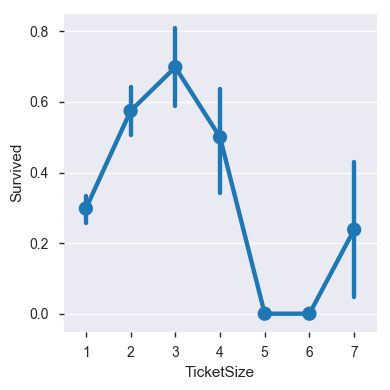

In [71]:
sb.factorplot(x="TicketSize", y="Survived", data=df);

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


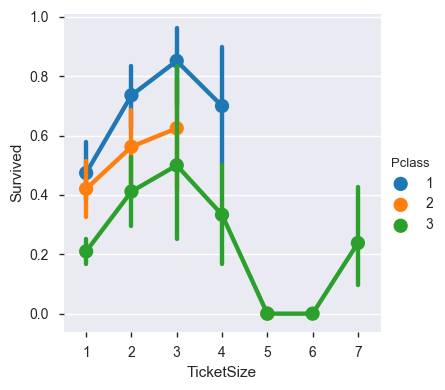

In [72]:
sb.factorplot(x="TicketSize", y="Survived", hue='Pclass', data=df);

### cabin allocation

In [73]:
df.Cabin.isnull().sum()

687

mostly nulls.

In [74]:
df['HasCabin'] = df.Cabin.notnull()

In [75]:
df[['Survived', 'HasCabin']].head(10)

,Survived,HasCabin
PassengerId,,
1,0,False
2,1,True
3,1,False
4,1,True
5,0,False
6,0,False
7,0,True
8,0,False
9,1,False


In [76]:
df.groupby('HasCabin').Survived.agg(['sum', 'count']).apply(lambda row: row['sum']/row['count'], axis=1)

HasCabin
False    0.299854
True     0.666667
dtype: float64

cabin allocation is much more likely to survive?  correlated to higher classes, perhaps.

In [77]:
df.groupby(['Pclass', 'HasCabin']).Survived.agg(['sum', 'count']).apply(lambda row: row['sum']/row['count'], axis=1)

Pclass  HasCabin
1       False       0.475000
        True        0.664773
2       False       0.440476
        True        0.812500
3       False       0.235908
        True        0.500000
dtype: float64

having a cabin assigned makes you more likely to survive across the board.

In [78]:
def rip_deck(cabin):
    try:
        return cabin[0]
    except:
        return "no_cabin"

In [79]:
df.Cabin.map(rip_deck).value_counts()

no_cabin    687
C            59
B            47
D            33
E            32
A            15
F            13
G             4
T             1
Name: Cabin, dtype: int64

In [80]:
df['Deck'] = df.Cabin.map(rip_deck)

In [81]:
df.groupby(['Deck']).Survived.agg(['sum', 'count']).apply(lambda row: row['sum']/row['count'], axis=1)

Deck
A           0.466667
B           0.744681
C           0.593220
D           0.757576
E           0.750000
F           0.615385
G           0.500000
T           0.000000
no_cabin    0.299854
dtype: float64

In [82]:
df.groupby(['Pclass', 'Deck']).Survived.agg(['sum', 'count']).apply(lambda row: row['sum']/row['count'], axis=1)

Pclass  Deck    
1       A           0.466667
        B           0.744681
        C           0.593220
        D           0.758621
        E           0.720000
        T           0.000000
        no_cabin    0.475000
2       D           0.750000
        E           0.750000
        F           0.875000
        no_cabin    0.440476
3       E           1.000000
        F           0.200000
        G           0.500000
        no_cabin    0.235908
dtype: float64

let's keep this.

In [83]:
class DeckImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.map(rip_deck)

In [84]:
mapper.features.append(('Cabin', [DeckImputer(), LabelBinarizer()], {"alias": "Deck"}))

### family size

similarly, want to encode total family size from `Parch` and `SibSp` (parent-child and sibling/spouse relationships respectively)

In [85]:
mapper.features.append(("Parch", None))
mapper.features.append(("SibSp", None))

In [86]:
class FamilySize(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X['Parch'] + X['SibSp'] + 1

In [87]:
mapper.features.append((["Parch", "SibSp"], FamilySize(), {"alias": "FamilySize"}))

In [88]:
df['FamilySize'] = df["Parch"] + df["SibSp"] + 1

In [89]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexMapped,Title,TitleMunged,NameLength,TicketPrefix,TicketSize,HasCabin,Deck,FamilySize
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,other,23,A5,1,False,no_cabin,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Mrs,woman,51,PC,1,True,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,woman,22,STONO2,1,False,no_cabin,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Mrs,woman,44,no_prefix,2,True,C,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,other,24,no_prefix,1,False,no_cabin,1


### family size vs ticket size

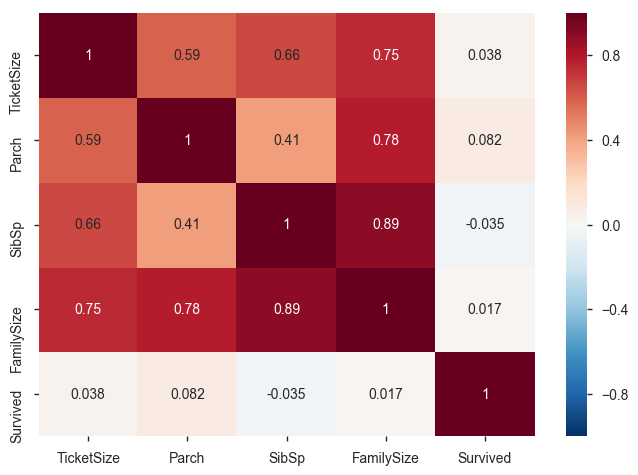

In [90]:
sb.heatmap(df.loc[:, ["TicketSize", "Parch", "SibSp", "FamilySize", "Survived"]].corr(), annot=True);

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


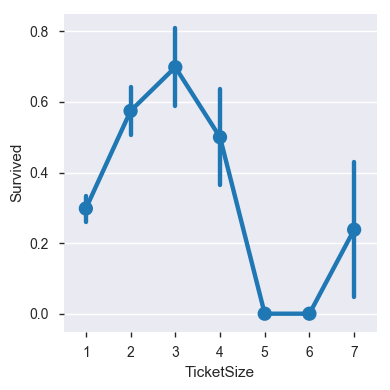

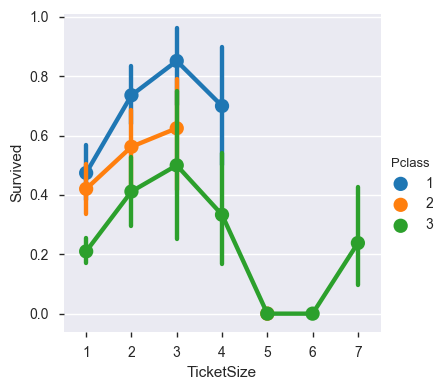

In [91]:
sb.factorplot(x="TicketSize", y="Survived", data=df);
sb.factorplot(x="TicketSize", y="Survived", hue="Pclass", data=df);

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


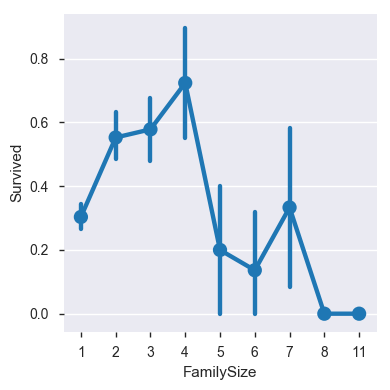

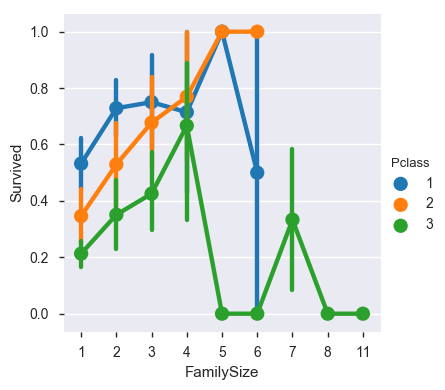

In [92]:
sb.factorplot(x="FamilySize", y="Survived", data=df);
sb.factorplot(x="FamilySize", y="Survived", hue="Pclass", data=df);

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


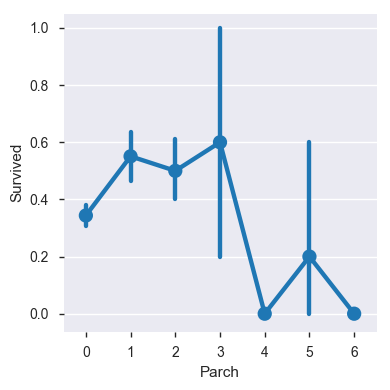

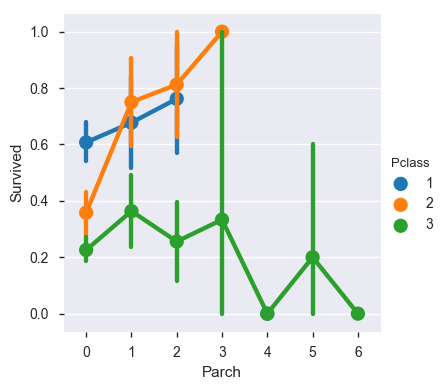

In [93]:
sb.factorplot(x="Parch", y="Survived", data=df);
sb.factorplot(x="Parch", y="Survived", hue="Pclass", data=df);

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


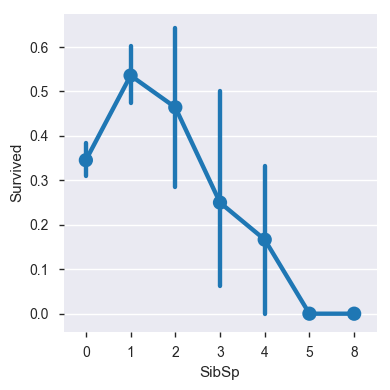

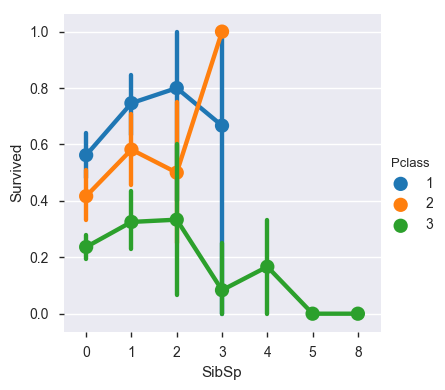

In [94]:
sb.factorplot(x="SibSp", y="Survived", data=df);
sb.factorplot(x="SibSp", y="Survived", hue="Pclass", data=df);

let's add some categoricals encoding family size as well.

In [95]:
class FamilyCategoricals(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        family_size = X.Parch + X.SibSp + 1
        def encode(val):
            if val == 1:
                return "solo"
            elif val <= 4:
                return "small"
            else:
                return "large"
        return family_size.map(encode)

In [96]:
df['FamilySizeCategory'] = FamilyCategoricals().transform(df.loc[:, ["Parch", "SibSp"]])

/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/john/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


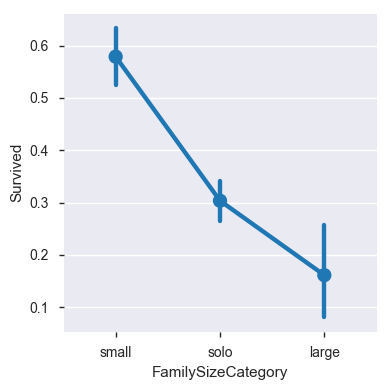

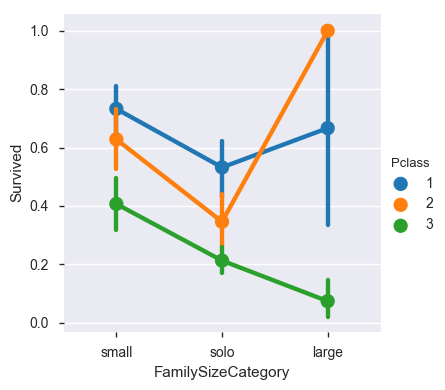

In [97]:
sb.factorplot(x="FamilySizeCategory", y="Survived", data=df);
sb.factorplot(x="FamilySizeCategory", y="Survived", hue="Pclass", data=df);

In [98]:
mapper.features.append((["Parch", "SibSp"], [FamilyCategoricals(), LabelBinarizer()], {"alias": "FamilySize"}))

In [99]:
mapper.fit_transform(df)

,Survived,Sex,Pclass,Title,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_unknown,Age,...,Deck_F,Deck_G,Deck_T,Deck_no_cabin,Parch,SibSp,FamilySize,FamilySize_large,FamilySize_small,FamilySize_solo
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,3.0,0.0,1.981001,0.0,0.0,1.0,0.0,22.000000,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0
2,1.0,0.0,1.0,1.0,4.266662,1.0,0.0,0.0,0.0,38.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
3,1.0,0.0,3.0,1.0,2.070022,0.0,0.0,1.0,0.0,26.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,1.0,3.972177,0.0,0.0,1.0,0.0,35.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0
5,0.0,1.0,3.0,0.0,2.085672,0.0,0.0,1.0,0.0,35.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6,0.0,1.0,3.0,0.0,2.135148,0.0,1.0,0.0,0.0,26.507589,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
7,0.0,1.0,1.0,0.0,3.948596,0.0,0.0,1.0,0.0,54.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,1.0,3.0,0.0,3.048088,0.0,0.0,1.0,0.0,2.000000,...,0.0,0.0,0.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0
9,1.0,0.0,3.0,1.0,2.409941,0.0,0.0,1.0,0.0,27.000000,...,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,1.0,0.0


let's go with it.

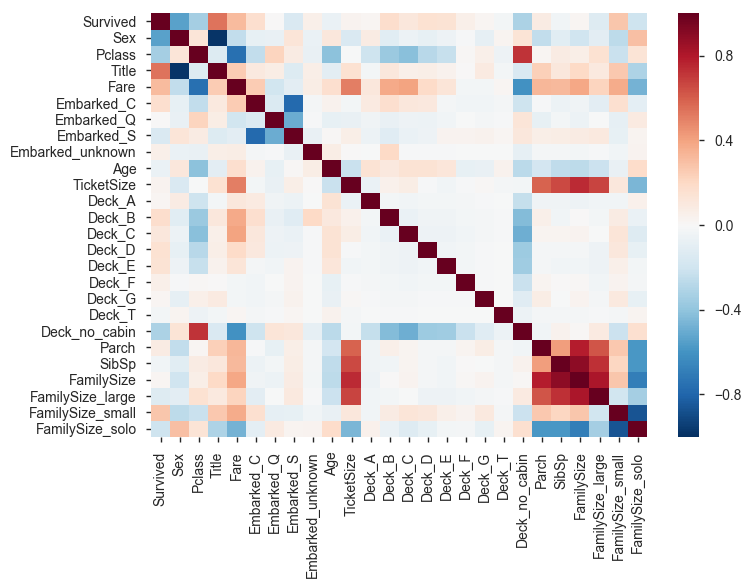

In [100]:
sb.heatmap(mapper.transform(df).corr());

In [101]:
mapper.transform(df).corr()['Survived'].sort_values()

Sex                -0.543351
Pclass             -0.338481
Deck_no_cabin      -0.316912
FamilySize_solo    -0.203367
Embarked_S         -0.155660
FamilySize_large   -0.125147
Age                -0.067485
SibSp              -0.035322
Deck_T             -0.026456
Embarked_Q          0.003650
Deck_G              0.016040
FamilySize          0.016639
Deck_A              0.022287
TicketSize          0.038247
Deck_F              0.057935
Embarked_unknown    0.060095
Parch               0.081629
Deck_C              0.114652
Deck_E              0.145321
Deck_D              0.150716
Embarked_C          0.168240
Deck_B              0.175095
FamilySize_small    0.279855
Fare                0.318251
Title               0.543175
Survived            1.000000
Name: Survived, dtype: float64

In [102]:
mapper.transform(df).to_csv("data/train_preprocessed.csv", index=True)

In [103]:
test['Survived'] = None

In [104]:
mapper.transform(test).to_csv("data/test_preprocessed.csv", index=True)